In [34]:
import numpy as np
from scipy.integrate import odeint

import torch
from torch.autograd import Function
import torch.nn as nn
import pyro
from pyro.distributions import Normal, Uniform, Delta
from pyro.infer.autoguide import AutoIAFNormal, AutoDiagonalNormal, AutoMultivariateNormal, init_to_mean
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, EmpiricalMarginal, TracePredictive
from pyro.optim import ClippedAdam, AdagradRMSProp

import matplotlib.pyplot as plt
%matplotlib inline

In [35]:
class GoodwinModel(object):

    def __init__(self, y0=None):

        if y0 is None:
            self._y0 = np.array([0,0,0], dtype=float)
        else:
            self._y0 = np.array(y0, dtype=float)
            
    def simulate(self, parameters, times):
        return self._simulate(parameters, times, None, None, False)

    def simulate_with_sensitivities(self, parameters, times, yt, g):
        return self._simulate(parameters, times, yt, g, True)

    def _simulate(self, parameters, times, yt, g, sensitivities):
        #print(parameters.shape)
        a1, a2, alpha, k1, k2 = [float(x) for x in parameters]
        times = np.asarray(times)

        def r(y, t, p):
            
            X1, X2, X3=y
            dX1_dt = (a1/( 1 + (a2*(X3**10)) ) ) - (alpha*X1);
            dX2_dt = (k1*X1) - (alpha*X2);
            dX3_dt = (k2*X2) - (alpha*X3);
            
            return dX1_dt,dX2_dt,dX3_dt

        if sensitivities:
            def jac(y):
                X1, X2, X3 = y
                ret = np.empty((3, 3))
                ret[0, 0] = -alpha
                ret[0, 1] = 0
                ret[0, 2] = -(a1*a2*10*(X3**9))/( (1 + a2*(X3**10))**2 )
                
                ret[1, 0] = k1
                ret[1, 1] = -alpha
                ret[1, 2] = 0
                
                ret[2, 0] = 0
                ret[2, 1] = k2
                ret[2, 2] = -alpha
                return ret

            def dfdp(y):
                X1, X2, X3 = y
                ret = np.empty((3, 5))
                ret[0, 0] = 1/(1+a2*(X3**10))
                ret[0, 1] = -(a1*(X3**10))/( (1 + a2*(X3**10))**2 )
                ret[0, 2] = -X1
                ret[0, 3] = 0
                ret[0, 4] = 0
                
                ret[1, 0] = 0
                ret[1, 1] = 0
                ret[1, 2] = -X2
                ret[1, 3] = X1
                ret[1, 4] = 0
                
                ret[2, 0] = 0
                ret[2, 1] = 0
                ret[2, 2] = -X3
                ret[2, 3] = 0
                ret[2, 4] = X2               
                return ret

            def augmented_dynamics(aug_state, t, p):
                y_t, neg_adj_t, _,_ = unpack(aug_state)
                dy_dt_t = r(y_t, t, p)
                dfdp_t = dfdp(y_t)
                jac_t = jac(y_t)
                vjp_y = np.dot(-neg_adj_t, jac_t)
                vjp_th = np.dot(-neg_adj_t, dfdp_t)
                vjp_t = np.dot(-neg_adj_t, dy_dt_t)
                
                return np.hstack((dy_dt_t, vjp_y, vjp_t, vjp_th))

            T, D = np.shape(yt)
            
            def unpack(x):
                return x[ 0 : D], x[D : 2*D], x[2*D], x[2*D + 1:]
            
            vjp_y = g[-1, :]
            vjp_t0 = 0
            time_vjp_list = []
            vjp_params = np.zeros(np.size(parameters))

            for i in range(T - 1, 0, -1):

                # Compute effect of moving measurement time.
                vjp_cur_t = np.dot(r(yt[i, :], times[i], parameters), g[i, :])
                time_vjp_list.append(vjp_cur_t)
                vjp_t0 = vjp_t0 - vjp_cur_t

                # Run augmented system backwards to the previous observation.
                aug_y0 = np.hstack((yt[i, :], vjp_y, vjp_t0, vjp_params))
                #print(aug_y0.shape)
                aug_ans = odeint(augmented_dynamics, aug_y0,
                                 np.array([times[i], times[i - 1]]), (parameters,), rtol=1e-5, atol=1e-6)
                _, vjp_y, vjp_t0, vjp_params = unpack(aug_ans[1])

                # Add gradient from current output.
                vjp_y = vjp_y + g[i - 1, :]

            time_vjp_list.append(vjp_t0)
            vjp_times = np.hstack(time_vjp_list)[::-1]
            
            return vjp_params
            
        else:
            values = odeint(r, self._y0, times, (parameters,), rtol=1e-5, atol=1e-6)
            return values
ode_model = GoodwinModel();

Text(0, 0.5, 'Value')

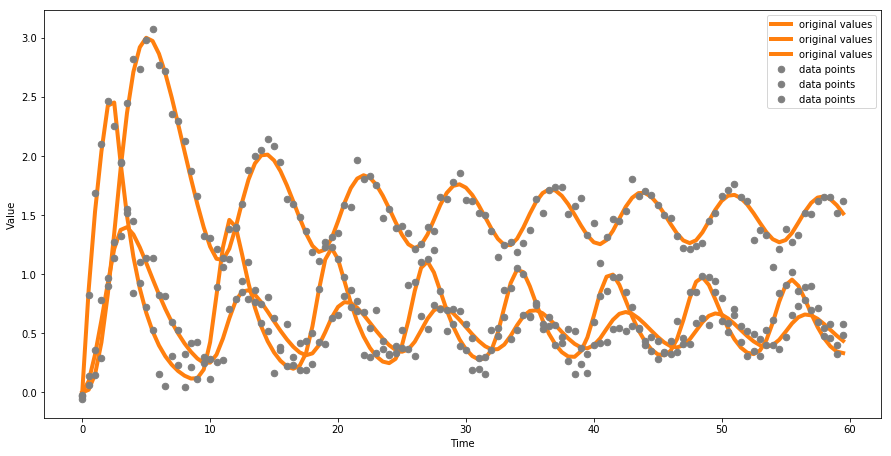

In [36]:
times = np.arange(0,60, 0.5)
sigma=0.1
real_params = [1.97,0.15,0.53,0.46,1.49]
sol=ode_model.simulate(real_params, times)
np.random.seed(121) #np.random.seed(111)
Y=sol+np.random.randn(120,3)*sigma
plt.figure(figsize=(15, 7.5))
plt.plot(times, sol, '-', color='#ff7f0e', lw=4, label='original values')
plt.plot(times, Y, 'o', color='#7f7f7f', ms=6.5, label='data points')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')

In [37]:
def forwardModel(params):
    times = np.arange(0,60, 0.5)  
    values = ode_model.simulate(params, times)
    
    return values

def backwardModel(params, forward_sol, adjoint):
    times = np.arange(0,60, 0.5)
    jac = ode_model.simulate_with_sensitivities(params, times, forward_sol, adjoint)
    
    return jac

In [38]:
class ODEop(Function):    
    @staticmethod
    def forward(ctx, x):
        numpy_x = x.detach().numpy()
        sol = forwardModel(numpy_x)
        ctx.save_for_backward(x, torch.as_tensor(sol, dtype=x.dtype))
        return x.new(sol)

    @staticmethod
    def backward(ctx, grad_output):
        T = 120
        d = 5
        v = grad_output.detach().numpy()
        numpy_x = ctx.saved_tensors[0].detach().numpy()
        numpy_sol = ctx.saved_tensors[1].detach().numpy()
        numpy_vsp = backwardModel(numpy_x, numpy_sol, v)
        
        return grad_output.new(numpy_vsp)
def my_ODE_func(parameters):
    return ODEop.apply(parameters)

In [39]:
class OdeModel(nn.Module):
    def __init__(self):        
        super(OdeModel, self).__init__()        
        self.factors = nn.Parameter(torch.empty(5))        
        
    def forward(self,x):        
        return my_ODE_func(self.factors) 
my_ode_model = OdeModel()

In [40]:
y_torch = torch.tensor(Y,dtype=torch.float)

In [41]:
def model(y_data):
    factors_prior = dist.Gamma(torch.tensor([2.0,2.0,2.0,2.0,2.0]),1.0).to_event(1)    
    priors = {'factors': factors_prior}
    scale = pyro.sample("scale", dist.HalfNormal(1.0))
    lifted_module = pyro.random_module("module", my_ode_model, priors)
    lifted_ode_model = lifted_module()
    prediction_mean = lifted_ode_model(y_data)
    with pyro.plate("map", len(y_data)):

        pyro.sample("obs",
                    Normal(prediction_mean, scale).to_event(1),
                    obs=y_data)
        return prediction_mean, lifted_ode_model

In [42]:
pyro.set_rng_seed(121)
pyro.clear_param_store()
guide = AutoMultivariateNormal(model)
optim = AdagradRMSProp({"eta": 0.1})
svi = SVI(model, guide, optim, loss=Trace_ELBO(), num_samples=5)
lifted_model = model(y_torch)[1]

In [43]:
def train():

    loss_trace = []
    for j in range(30000):
        # calculate the loss and take a gradient step

        loss = svi.step(y_torch)
        loss_trace.append(loss)

        if j % 500 == 0:
            print("[iteration %04d] loss: %.4f" % (j + 1, np.mean(loss_trace[-100:])))
#        if np.mean(loss_trace[-100:]) <-200 and j>1000:
#            break;
    return loss_trace

In [44]:
%%time
loss_graph = train()
for name, param in lifted_model.named_parameters():
        print(name, param.data.numpy())

[iteration 0001] loss: 419.2094
[iteration 0501] loss: 87.1759
[iteration 1001] loss: -73.2525
[iteration 1501] loss: -207.8886
[iteration 2001] loss: -257.7261
[iteration 2501] loss: -273.9672
[iteration 3001] loss: -280.0783
[iteration 3501] loss: -285.7829
[iteration 4001] loss: -290.1138
[iteration 4501] loss: -289.2697
[iteration 5001] loss: -292.2286
[iteration 5501] loss: -293.4724
[iteration 6001] loss: -294.1112
[iteration 6501] loss: -294.3497
[iteration 7001] loss: -294.7564
[iteration 7501] loss: -295.5377
[iteration 8001] loss: -296.2894
[iteration 8501] loss: -296.0733
[iteration 9001] loss: -296.4276
[iteration 9501] loss: -297.1628
[iteration 10001] loss: -297.8843
[iteration 10501] loss: -297.7266
[iteration 11001] loss: -297.4690
[iteration 11501] loss: -297.5362
[iteration 12001] loss: -298.1864
[iteration 12501] loss: -297.7779
[iteration 13001] loss: -297.7995
[iteration 13501] loss: -298.4047
[iteration 14001] loss: -299.7231
[iteration 14501] loss: -298.6434
[ite

In [45]:
svi.num_samples = 1000
posterior = svi.run(y_torch)

get_marginal = lambda traces, sites:EmpiricalMarginal(traces, sites)._get_samples_and_weights()[0].detach().cpu().numpy()
pyro_params = get_marginal(posterior, ['module$$$factors'])
pyro_vb_params=pyro_params.reshape((1000,5))

In [ ]:
from pyro.infer.mcmc import NUTS
from pyro.infer.mcmc.api import MCMC

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=2000, warmup_steps=1000)
mcmc.run(y_torch)

hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

In [46]:
pyro_vb_params1 = get_marginal(posterior, ['scale']).reshape((-1,1))
vb_params=np.concatenate((pyro_vb_params,pyro_vb_params1),axis=1)
np.savetxt('paper_gw_vb_adj.txt',vb_params)
vb_params.shape

(1000, 6)